# Importing Necessary Libraries

In [2]:
# OS and Warning files
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

# Analysis Libraries
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import svm, tree, ensemble, neighbors, linear_model
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualization Library
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

%matplotlib inline

In [3]:
# plotly.tools.set_credentials_file(username='neelrast', api_key='tH7Ty1sAOwl8O3JnfLmf')

# Import RL Data

In [4]:
# Loading RL Features Dataset
storm_rl_df = pd.read_csv("../data/storm_rl_norm.csv")
storm_rl_df["cost_category"] = storm_rl_df["cost_category"].astype('category')
storm_rl_df.head()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category
0,Bob,15.005262,0,1,0,1003,65,0.0,0.0,7,0,1,0,7.5,-0.6,5.963532e+05,moderate
1,Danny,12.080622,1,0,0,987,80,0.0,8.0,27,0,0,0,1.9,-0.4,1.250277e+06,high
2,Elena,19.448238,0,1,0,959,100,10.0,0.0,16,0,1,0,1.4,1.0,3.320953e+07,severe
3,Gloria,31.092933,0,0,0,942,90,0.0,0.0,12,1,0,0,1.3,0.3,0.000000e+00,minimal
4,Gloria,45.238814,0,1,0,961,75,0.0,0.0,12,0,0,0,3.0,0.2,0.000000e+00,minimal


In [5]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
dtypes: category(1), float64(6), int64(9), object(1)
memory usage: 14.8+ KB


In [6]:
storm_rl_df["moon_phase"] = abs(abs(storm_rl_df.moon_phase - 14)-7)

In [7]:
storm_rl_df["cost_category"].unique()

[moderate, high, severe, minimal, low, catastrophic]
Categories (6, object): [moderate, high, severe, minimal, low, catastrophic]

In [8]:
cateogry_types = ['low', 'minimal', 'moderate', 'high', 'severe',  'catastrophic']

storm_rl_df["cost_category_num"] = storm_rl_df.cost_category.astype("category", categories=cateogry_types).cat.codes

In [9]:
#Loading winds and rain data
winds_rain = pd.read_csv("../data/wind_rain.csv")
winds_rain = winds_rain.drop(columns={"Rain Rate"})
winds_rain.head()

,storm_names,year,month,day,Max Radii,Point Maxima
0,Bob,1985,7,25,NaN,21.50
1,Danny,1985,8,15,NaN,9.80
2,Elena,1985,9,2,NaN,15.67
3,Gloria,1985,9,27,NaN,9.70
4,Gloria,1985,9,27,NaN,9.70


In [10]:
winds_rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 6 columns):
storm_names     115 non-null object
year            115 non-null int64
month           115 non-null int64
day             115 non-null int64
Max Radii       104 non-null float64
Point Maxima    115 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 5.5+ KB


In [11]:
winds_rain = winds_rain.fillna(0)

In [12]:
storm_rl_df["year"] = winds_rain.year
storm_rl_df["month"] = winds_rain.month
storm_rl_df["day"] = winds_rain.day
storm_rl_df["Max Radii"] = winds_rain["Max Radii"]
storm_rl_df["Point Maxima"] = winds_rain["Point Maxima"]

In [13]:
storm_rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 23 columns):
storm_names           115 non-null object
eff_land_sp           115 non-null float64
direct                115 non-null int64
angled                115 non-null int64
cross                 115 non-null int64
press_mbars           115 non-null int64
max_sust_winds_kts    115 non-null int64
storm_surge           115 non-null float64
storm_tide            115 non-null float64
moon_phase            115 non-null int64
low_neap              115 non-null int64
high_neap             115 non-null int64
high_ebb              115 non-null int64
high_tide_line        115 non-null float64
low_tide_line         115 non-null float64
norm_cost             115 non-null float64
cost_category         115 non-null category
cost_category_num     115 non-null int8
year                  115 non-null int64
month                 115 non-null int64
day                   115 non-null int64
Max Radii          

## Data Exploration

In [14]:
storm_rl_df.groupby(storm_rl_df["cost_category"]).count()

,storm_names,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,...,high_ebb,high_tide_line,low_tide_line,norm_cost,cost_category_num,year,month,day,Max Radii,Point Maxima
cost_category,,,,,,,,,,,,,,,,,,,,,
catastrophic,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
high,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
low,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
minimal,48,48,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
moderate,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
severe,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


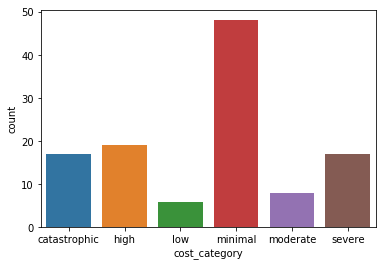

In [15]:
ax = sns.countplot(storm_rl_df["cost_category"],label="Count")

In [16]:
storm_rl_df['year'].value_counts()

2004    10
1998     8
2005     8
1985     7
2002     7
2008     6
1995     6
2017     6
1999     5
1996     4
2006     4
2012     4
2003     4
2001     3
2011     3
1989     3
1992     3
1994     3
1986     2
1991     2
2015     2
1997     2
2000     2
2016     2
2007     2
2010     1
2014     1
1993     1
2013     1
1988     1
1987     1
2009     1
Name: year, dtype: int64

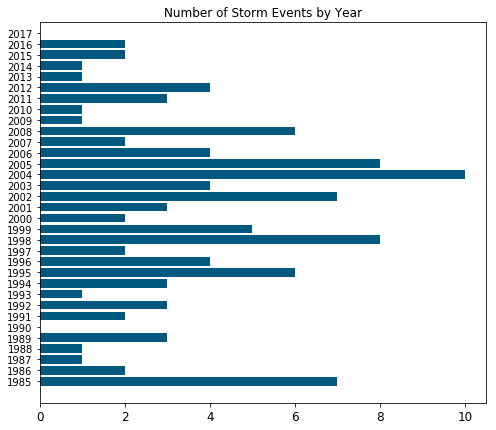

In [17]:
plt.figure(figsize=(8,7))
plt.barh(storm_rl_df['year'].value_counts().sort_index().index[:-1], 
         storm_rl_df['year'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Year', fontsize = 12)
plt.yticks(np.arange(1985,2018,1), fontsize = 10)
plt.xticks(fontsize = 12);

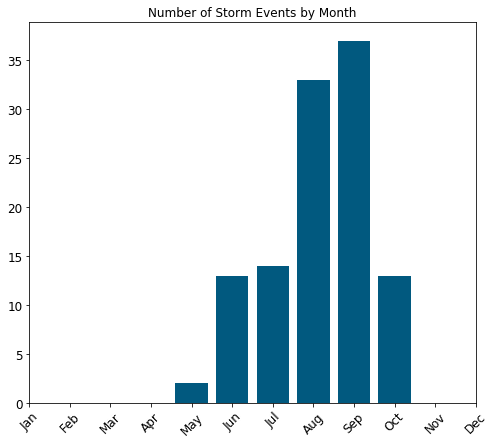

In [18]:
plt.figure(figsize=(8,7))
plt.bar(storm_rl_df['month'].value_counts().sort_index().index[:-1], 
         storm_rl_df['month'].value_counts().sort_index().values[:-1], color = '#01597f')
plt.title('Number of Storm Events by Month', fontsize = 12)
plt.xticks(range(1,13),['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],
           rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12);

In [19]:
coordinates = pd.read_csv("../data/storm_main.csv")

In [20]:
coordinates = coordinates.drop(columns={'time', 'zone', 'max_winds_kts', 'SS', 'pre_lat', 'pre_long', 'sub_lat',
       'sub_long', 'dir', 'sp1', 'sp2', 'frame', 'hours', 'eff_wind_sp',
       'angle_binary', 'direct', 'angled', 'cross', 'press_mbars',
       'max_sust_winds_kts', 'width_storm', 'storm_surge', 'storm_tide',
       'moon_phase', 'tide_phase', 'low_neap', 'high_neap', 'high_ebb',
       'high_tide_line', 'low_tide_line', 'rate_rainfall', 'total_rainfall',
       'deaths', 'states_affected', 'damage_unadj', 'col_index',
       'infaltion_adj'})
coordinates["norm_cost"] = storm_rl_df["norm_cost"]
coordinates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 7 columns):
storm_names    115 non-null object
year           115 non-null int64
month          115 non-null int64
day            115 non-null int64
lat_n          115 non-null float64
long_w         115 non-null float64
norm_cost      115 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 6.4+ KB


In [21]:
coordinates['text'] = 'Hurricane ' + coordinates['storm_names'] + '<br>Occured on ' + coordinates['month'].astype('str') + '/' + coordinates['day'].astype('str') + '/' + coordinates['year'].astype('str') + ' <br>Norm. Damage '  +  coordinates['norm_cost'].map('${:,}'.format).astype('str')

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [go.Scattergeo(
        locationmode = 'USA-states',
        lon = -1*coordinates['long_w'],
        lat = coordinates['lat_n'],
        text = coordinates['text'],
        mode = 'markers',
        marker = dict( 
            size = 8, 
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = coordinates['norm_cost'],
            cmax = coordinates['norm_cost'].max(),
            colorbar=dict(
                title="Normalized Damage caused by Storm Events <br> since 1985 till 2018"
            )
        ))]

layout = dict(
        title = 'Coordinates of Storm Events which caused land slides at point of impact.', 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5        
        ),
    )

fig = go.Figure(data=data, layout=layout )
py.iplot(fig, filename='storm-events')

In [22]:
# X_rl -> features
# y_rl -> labels

X_rl = storm_rl_df.drop(columns={"storm_names","year","month","day","norm_cost","cost_category","cost_category_num"})
y_rl = storm_rl_df["cost_category_num"]
classes = pd.merge(y_rl, storm_rl_df["cost_category"], left_index=True,  right_index =True)

In [23]:
X_rl.head()

,eff_land_sp,direct,angled,cross,press_mbars,max_sust_winds_kts,storm_surge,storm_tide,moon_phase,low_neap,high_neap,high_ebb,high_tide_line,low_tide_line,Max Radii,Point Maxima
0,15.005262,0,1,0,1003,65,0.0,0.0,0,0,1,0,7.5,-0.6,0.0,21.50
1,12.080622,1,0,0,987,80,0.0,8.0,6,0,0,0,1.9,-0.4,0.0,9.80
2,19.448238,0,1,0,959,100,10.0,0.0,5,0,1,0,1.4,1.0,0.0,15.67
3,31.092933,0,0,0,942,90,0.0,0.0,5,1,0,0,1.3,0.3,0.0,9.70
4,45.238814,0,1,0,961,75,0.0,0.0,5,0,0,0,3.0,0.2,0.0,9.70


## Classifiers

In [51]:
classifiers = []

model1 = xgboost.XGBClassifier()
classifiers.append(['XGBoost', model1])

model2 = svm.SVC(kernel = 'linear', C = 1)
classifiers.append(['SVM', model2])

model3 = tree.DecisionTreeClassifier()
classifiers.append(['Decision Trees', model3])

model4 = ensemble.RandomForestClassifier(max_depth = 10)
classifiers.append(['Random Forest', model4])

model5 = neighbors.KNeighborsClassifier(n_neighbors = 7)
classifiers.append(['KNN', model5])

model6 = linear_model.LogisticRegressionCV(cv=4, multi_class='multinomial')
classifiers.append(['Logistic Regression',model6])

### RL Feature Set

In [52]:
rl_acc = []
rl_mse = []
names = []

i = 0

while i <= 30:
    # Dividing X, y into train and test data by .33 randomly
    X_train, X_test, y_train, y_test = train_test_split(X_rl, y_rl, test_size=0.33, random_state=42) 

    for name, model in classifiers:
        names.append(name) 

        model.fit(X_train, y_train)
        y_pred= model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        #print("Model:\n%s\n\nAccuracy:\n%s\n"%(name, acc*100))
        rl_acc.append([name, acc])

        mse = mean_squared_error(y_test, y_pred)
        #print("Mean Squared Error:\n%s\n"%(mse))
        rl_mse.append([name, mse])
    i = i+1
print("Done")

Done


In [53]:
df_acc = pd.DataFrame(rl_acc, columns = {"names", "acc"})
df_acc.head()

,names,acc
0,XGBoost,0.578947
1,SVM,0.447368
2,Decision Trees,0.552632
3,Random Forest,0.421053
4,KNN,0.394737


In [54]:
df_mse = pd.DataFrame(rl_mse, columns = {"names", "mse"})
df_mse.head()

,names,mse
0,XGBoost,4.552632
1,SVM,4.842105
2,Decision Trees,3.447368
3,Random Forest,5.315789
4,KNN,6.552632


In [55]:
df_mse.groupby(df_mse.names).describe()

mse                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  4.198642  5.004540e-01  2.736842  3.907895   
KNN                  31.0  6.552632  9.028600e-16  6.552632  6.552632   
Logistic Regression  31.0  4.684211  9.028600e-16  4.684211  4.684211   
Random Forest        31.0  4.300509  8.524522e-01  2.473684  3.644737   
SVM                  31.0  4.842105  1.805720e-15  4.842105  4.842105   
XGBoost              31.0  4.552632  9.028600e-16  4.552632  4.552632   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       4.263158  4.500000  5.078947  
KNN                  6.552632  6.552632  6.552632  
Logistic Regression  4.684211  4.684211  4.684211  
Random Forest        4.500000  4.907895  5.710526  
SVM                  4.842105  4.842105  4.842105  
XGBoost              4.552632  4.552632  4.552632

In [56]:
df_acc.groupby(df_mse.names).describe()

acc                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  0.521222  4.824690e-02  0.447368  0.473684   
KNN                  31.0  0.394737  1.128575e-16  0.394737  0.394737   
Logistic Regression  31.0  0.421053  2.821438e-16  0.421053  0.421053   
Random Forest        31.0  0.502547  5.779690e-02  0.342105  0.473684   
SVM                  31.0  0.447368  1.692863e-16  0.447368  0.447368   
XGBoost              31.0  0.578947  1.128575e-16  0.578947  0.578947   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       0.500000  0.565789  0.605263  
KNN                  0.394737  0.394737  0.394737  
Logistic Regression  0.421053  0.421053  0.421053  
Random Forest        0.500000  0.552632  0.631579  
SVM                  0.447368  0.447368  0.447368  
XGBoost              0.578947  0.578947  0.578947

### Feature Optimization for DT using MSE

Optimal number of features : 5


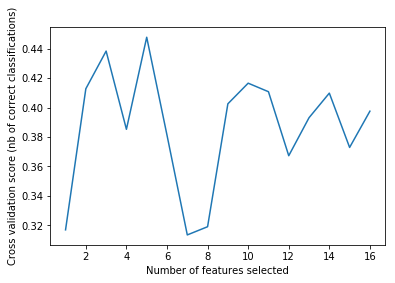

In [62]:
# Create the RFE object and compute a cross-validated score.
model = tree.DecisionTreeClassifier()
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5),
              scoring='accuracy')
rfecv.fit(X_rl, y_rl)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

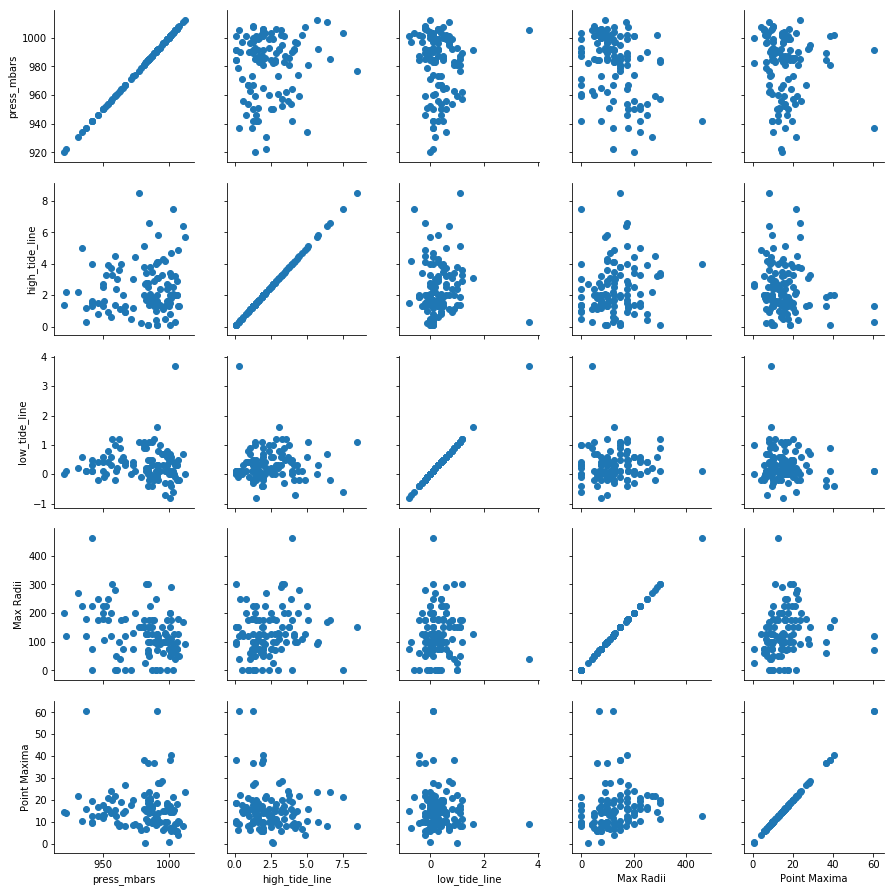

In [63]:
g = sns.PairGrid(X_rl[X_rl.columns[rfecv.support_]])
g.map(plt.scatter);

In [64]:
# Dropping columns which are not selected in our RFE Test.
X_rl = X_rl[X_rl.columns[rfecv.support_]]
X_rl = X_rl.astype("float64")

In [65]:
X_rl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
press_mbars       115 non-null float64
high_tide_line    115 non-null float64
low_tide_line     115 non-null float64
Max Radii         115 non-null float64
Point Maxima      115 non-null float64
dtypes: float64(5)
memory usage: 4.6 KB


In [66]:
# calculate the correlation matrix
corr = X_rl.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

,press_mbars,high_tide_line,low_tide_line,Max Radii,Point Maxima
press_mbars,1,0.1,-0.041,-0.33,-0.1
high_tide_line,0.1,1,0.018,0.15,-0.15
low_tide_line,-0.041,0.018,1,0.031,-0.12
Max Radii,-0.33,0.15,0.031,1,0.15
Point Maxima,-0.1,-0.15,-0.12,0.15,1



----------


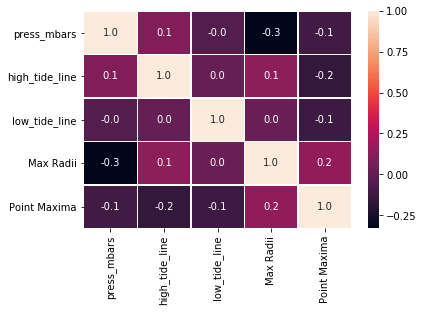

In [67]:
# correlation map
print("\n----------")
f,ax = plt.subplots()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

### Understand Decision Trees and Feature Importance

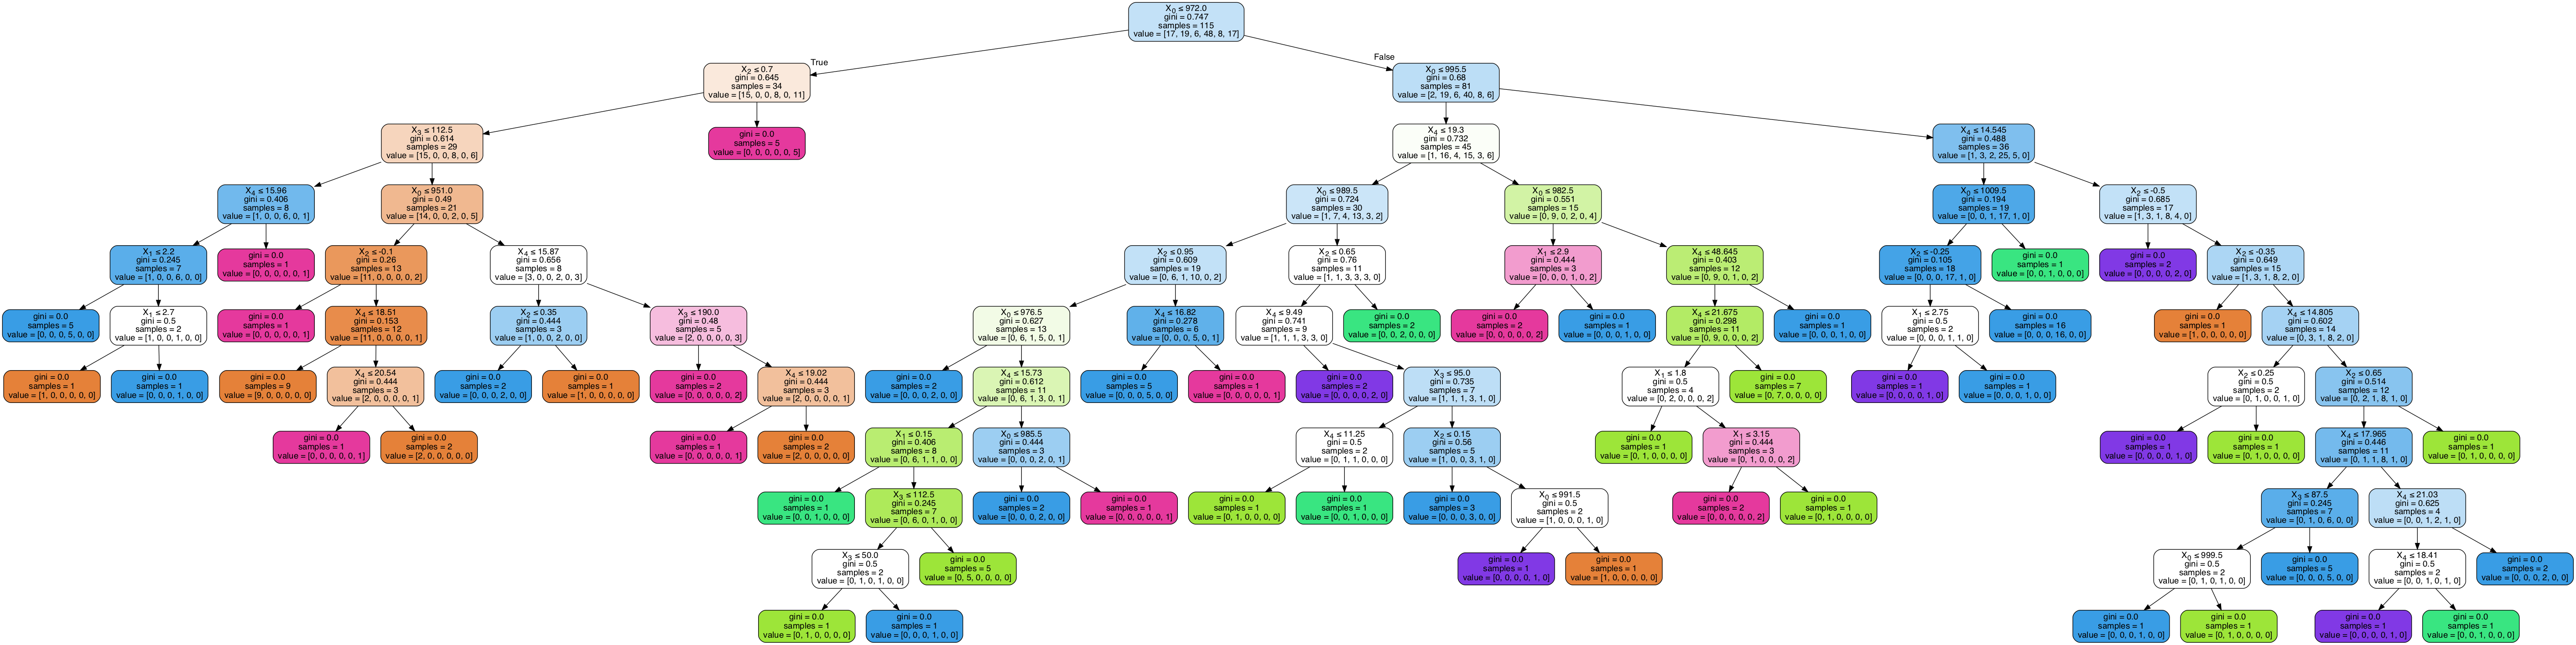

In [68]:
dtree = tree.DecisionTreeClassifier(max_depth = 10)
dtree.fit(X_rl, y_rl)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [69]:
print(dict(zip(X_rl.columns, dtree.feature_importances_*100)))

{'press_mbars': 29.788568378127962, 'high_tide_line': 8.82496795520475, 'low_tide_line': 21.707145716669263, 'Max Radii': 10.584706598619043, 'Point Maxima': 29.094611351378987}


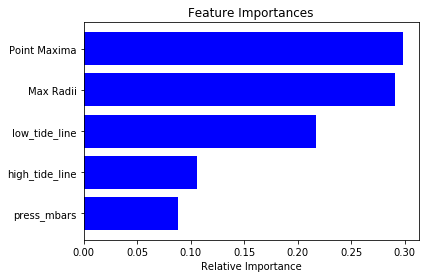

In [70]:
importances = dtree.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), X_rl.columns)
plt.xlabel('Relative Importance')
plt.show()

# Import SS Data

In [71]:
# Loading Saffir Simpson Dataset
storm_ss_df = pd.read_csv("../data/storm_ss_norm.csv")
storm_ss_df["cost_category_num"] = storm_ss_df.cost_category.astype('category').cat.codes
storm_ss_df = storm_ss_df.fillna(0)
storm_ss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 5 columns):
storm_names          115 non-null object
SS                   115 non-null int64
norm_cost            115 non-null float64
cost_category        115 non-null object
cost_category_num    115 non-null int8
dtypes: float64(1), int64(1), int8(1), object(2)
memory usage: 3.8+ KB


In [72]:
# X_ss -> features
# y_ss -> labels

X_ss = storm_ss_df.drop(columns={"storm_names","norm_cost","cost_category","cost_category_num"})
y_ss = storm_ss_df.cost_category_num
classes = storm_ss_df.cost_category

## Classifiers

In [73]:
# Dividing X, y into train and test data by 80 events and 35 events 
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

In [74]:
ss_acc = []
ss_mse = []

names_ss = []
i = 0

while i <= 30:
    # Dividing X, y into train and test data by 80 events and 35 events 
    X_train, X_test, y_train, y_test = train_test_split(X_ss, y_ss, test_size=0.33, random_state = 42) 

    for name, model in classifiers:
        names.append(name) 

        model.fit(X_train, y_train)
        y_pred= model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        #print("Model:\n%s\n\nAccuracy:\n%s\n"%(name, acc*100))
        ss_acc.append([name, acc])

        mse = mean_squared_error(y_test, y_pred)
        #print("Mean Squared Error:\n%s\n"%(mse))
        ss_mse.append([name, mse])
        
    i = i + 1
print("Done.")

Done.


In [75]:
df_acc_ss = pd.DataFrame(ss_acc, columns = {"names", "acc"})

In [76]:
df_acc_ss.groupby(df_acc_ss.names).describe()

acc                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  0.447368  1.692863e-16  0.447368  0.447368   
KNN                  31.0  0.342105  2.257150e-16  0.342105  0.342105   
Logistic Regression  31.0  0.421053  2.821438e-16  0.421053  0.421053   
Random Forest        31.0  0.434635  3.522187e-02  0.368421  0.394737   
SVM                  31.0  0.421053  2.821438e-16  0.421053  0.421053   
XGBoost              31.0  0.447368  1.692863e-16  0.447368  0.447368   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       0.447368  0.447368  0.447368  
KNN                  0.342105  0.342105  0.342105  
Logistic Regression  0.421053  0.421053  0.421053  
Random Forest        0.447368  0.447368  0.500000  
SVM                  0.421053  0.421053  0.421053  
XGBoost              0.447368  0.447368  0.447368

In [77]:
df_mse_ss = pd.DataFrame(ss_mse, columns = {"names", "mse"})

In [78]:
df_mse_ss.groupby(df_mse_ss.names).describe()

mse                                              \
                    count      mean           std       min       25%   
names                                                                   
Decision Trees       31.0  4.605263  1.805720e-15  4.605263  4.605263   
KNN                  31.0  6.684211  1.805720e-15  6.684211  6.684211   
Logistic Regression  31.0  4.394737  1.805720e-15  4.394737  4.394737   
Random Forest        31.0  5.274194  1.072203e+00  3.289474  4.605263   
SVM                  31.0  6.631579  2.708580e-15  6.631579  6.631579   
XGBoost              31.0  4.973684  2.708580e-15  4.973684  4.973684   

                                                   
                          50%       75%       max  
names                                              
Decision Trees       4.605263  4.605263  4.605263  
KNN                  6.684211  6.684211  6.684211  
Logistic Regression  4.394737  4.394737  4.394737  
Random Forest        4.605263  6.289474  7.342105  
SVM                  6.631579  6.631579  6.631579  
XGBoost              4.973684  4.973684  4.973684

# Comparing results

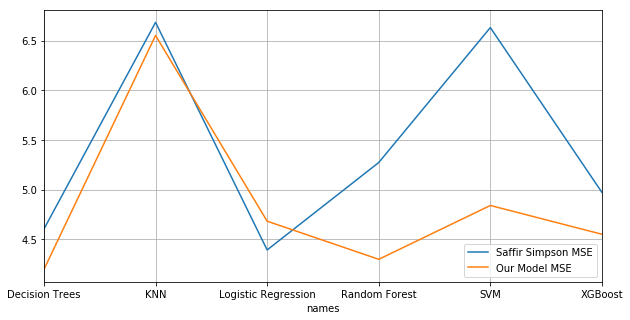

In [79]:
ax = df_mse_ss.groupby(df_mse_ss.names).mean().plot(figsize=(10,5), grid=True)
df_mse.groupby(df_mse.names).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['Saffir Simpson MSE', 'Our Model MSE'])

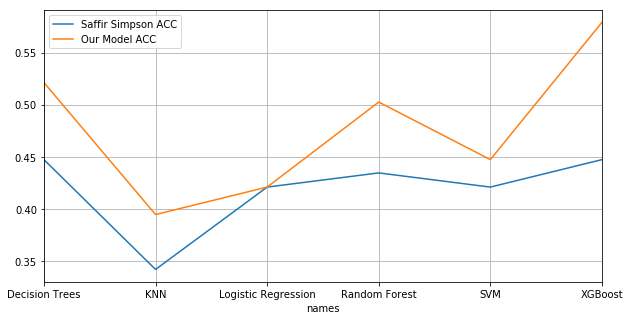

In [81]:
ax = df_acc_ss.groupby(df_acc_ss.names).mean().plot(figsize=(10,5), grid=True)
df_acc.groupby(df_acc.names).mean().plot(figsize=(10,5), grid=True, ax=ax)
ax.legend(['Saffir Simpson ACC', 'Our Model ACC'])